"""Columns Understanding 
Type: consisting of a letter L, M, or H for low, medium and high as product quality variants.

air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.

process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise.

torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.

tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

machine failure: whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 ~ 240 mins.

heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the rotational speed is below 1380 rpm

power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.

overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.

random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters."""


In [47]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder, Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [48]:
"""
current_directory=os.path.dirname(os.path.abspath("machine_failure_predictions_classic_model.ipynb"))
if os.name=="nt":
    current_directory=current_directory[0].upper()+current_directory[1:]
  
current_directory = current_directory.split(os.sep)

# Remove the unwanted part (e.g., 'Projects')
current_directory = [part for part in current_directory if part != 'notebooks']

# Reconstruct the path
current_directory = os.sep.join(current_directory)
train_path=os.path.join(current_directory,r"src\datasets\machine_failure\train.csv")
train_path


train_path=r"{}".format(train_path)


def replace_slashes(path, to_forward=True):
    if to_forward:
        return path.replace("\\", "/")
    else:
        return path.replace("/", "\\")
if os.name=="nt":
    train_path = replace_slashes(train_path, to_forward=True)


train_data = pd.read_csv(train_path)

"""


'\ncurrent_directory=os.path.dirname(os.path.abspath("machine_failure_predictions_classic_model.ipynb"))\nif os.name=="nt":\n    current_directory=current_directory[0].upper()+current_directory[1:]\n  \ncurrent_directory = current_directory.split(os.sep)\n\n# Remove the unwanted part (e.g., \'Projects\')\ncurrent_directory = [part for part in current_directory if part != \'notebooks\']\n\n# Reconstruct the path\ncurrent_directory = os.sep.join(current_directory)\ntrain_path=os.path.join(current_directory,r"src\\datasets\\machine_failure\train.csv")\ntrain_path\n\n\ntrain_path=r"{}".format(train_path)\n\n\ndef replace_slashes(path, to_forward=True):\n    if to_forward:\n        return path.replace("\\", "/")\n    else:\n        return path.replace("/", "\\")\nif os.name=="nt":\n    train_path = replace_slashes(train_path, to_forward=True)\n\n\ntrain_data = pd.read_csv(train_path)\n\n'

In [49]:
train_data = pd.read_csv("train.csv")


In [50]:
train_data

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


In [51]:
train_data=train_data.drop(['TWF','HDF','PWF','OSF','RNF',"id"],axis=1)


In [52]:

non_numeric_columns = train_data.select_dtypes(include=['object']).columns

# Apply Label Encoding to these columns
label_encoder = LabelEncoder()
for column in non_numeric_columns:
    train_data[column] = label_encoder.fit_transform(train_data[column])


<Axes: xlabel='Machine failure', ylabel='count'>

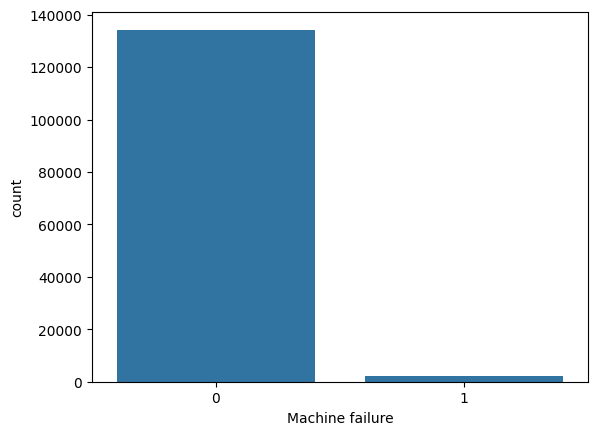

In [53]:
sns.countplot(x="Machine failure", data=train_data)

In [54]:
train_data

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,2752,1,300.6,309.6,1596,36.1,140,0
1,8620,2,302.6,312.1,1759,29.1,200,0
2,2344,1,299.3,308.5,1805,26.5,25,0
3,4704,1,301.0,310.9,1524,44.3,197,0
4,9727,2,298.0,309.0,1641,35.4,34,0
...,...,...,...,...,...,...,...,...
136424,9220,2,300.1,311.4,1530,37.5,210,0
136425,838,0,297.5,308.5,1447,49.1,2,0
136426,5502,1,300.5,311.8,1524,38.5,214,0
136427,5024,1,301.7,310.9,1447,46.3,42,0


In [55]:
train_data_failed=train_data[train_data['Machine failure']==1]
train_data_failed

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
130,4190,1,303.9,312.8,1345,56.5,21,1
164,3728,1,302.5,310.4,1307,54.8,174,1
228,7882,2,300.7,309.7,1878,27.9,20,1
236,6269,1,297.3,308.6,1258,61.8,144,1
247,3777,1,303.0,311.3,1341,51.0,174,1
...,...,...,...,...,...,...,...,...
135902,4289,1,302.6,312.1,1638,35.0,215,1
135917,6426,1,297.3,308.2,1553,33.5,208,1
135957,5958,1,299.1,310.6,1353,49.7,74,1
136053,555,0,302.4,312.0,1286,62.3,162,1


In [56]:
num_samples=train_data_failed['Machine failure'].count()


In [57]:
train_data_notfailed=train_data[train_data['Machine failure']==0]
train_data_notfailed_balanced = train_data_notfailed.sample(n=num_samples, random_state=42)

train_data_notfailed_balanced

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
21233,2045,1,298.5,308.1,1396,39.9,20,0
109133,6685,1,298.5,309.3,1605,40.1,131,0
41941,7534,2,297.9,307.7,1615,39.5,69,0
121308,7663,2,299.0,308.4,1535,47.5,153,0
79340,1324,1,297.5,309.3,1372,29.8,72,0
...,...,...,...,...,...,...,...,...
85964,695,0,300.8,310.6,1790,26.0,139,0
49208,9113,2,300.6,310.2,1772,27.1,23,0
122028,9445,2,299.0,310.4,1515,37.0,131,0
19120,4579,1,300.3,310.7,1427,46.3,190,0


In [58]:
balanced_train_data = pd.concat([train_data_notfailed_balanced, train_data_failed])
balanced_train_data

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
21233,2045,1,298.5,308.1,1396,39.9,20,0
109133,6685,1,298.5,309.3,1605,40.1,131,0
41941,7534,2,297.9,307.7,1615,39.5,69,0
121308,7663,2,299.0,308.4,1535,47.5,153,0
79340,1324,1,297.5,309.3,1372,29.8,72,0
...,...,...,...,...,...,...,...,...
135902,4289,1,302.6,312.1,1638,35.0,215,1
135917,6426,1,297.3,308.2,1553,33.5,208,1
135957,5958,1,299.1,310.6,1353,49.7,74,1
136053,555,0,302.4,312.0,1286,62.3,162,1


In [59]:
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_train_data

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,4407,1,302.4,311.8,1509,45.7,108,1
1,2058,1,298.3,308.0,1326,50.3,65,1
2,2382,1,299.2,308.5,1295,62.3,101,1
3,858,0,297.4,308.7,1651,29.4,120,0
4,2261,1,299.4,309.0,1660,41.3,24,0
...,...,...,...,...,...,...,...,...
4291,5975,1,299.0,310.3,1303,68.6,71,1
4292,538,0,303.7,312.0,1419,48.7,74,0
4293,3451,1,301.9,310.4,1353,46.4,119,1
4294,3420,1,302.0,311.0,1555,37.7,200,1


<Axes: xlabel='Machine failure', ylabel='count'>

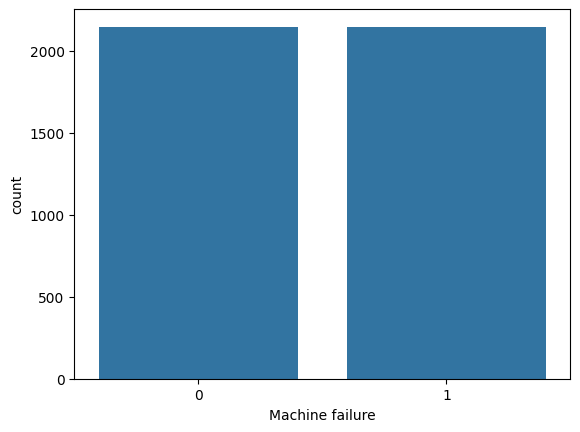

In [60]:
sns.countplot(x="Machine failure", data=balanced_train_data)

In [61]:
y=balanced_train_data['Machine failure']
x=balanced_train_data.drop(['Machine failure','Product ID','Type'],axis=1)
x

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,302.4,311.8,1509,45.7,108
1,298.3,308.0,1326,50.3,65
2,299.2,308.5,1295,62.3,101
3,297.4,308.7,1651,29.4,120
4,299.4,309.0,1660,41.3,24
...,...,...,...,...,...
4291,299.0,310.3,1303,68.6,71
4292,303.7,312.0,1419,48.7,74
4293,301.9,310.4,1353,46.4,119
4294,302.0,311.0,1555,37.7,200


In [62]:
y

0       1
1       1
2       1
3       0
4       0
       ..
4291    1
4292    0
4293    1
4294    1
4295    0
Name: Machine failure, Length: 4296, dtype: int64

In [63]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.3)

In [64]:

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(x_train, y_train)

# Predict and evaluate
y_pred = rf_classifier.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8572536850271528


Confusion Matrix:
[[583  76]
 [108 522]]


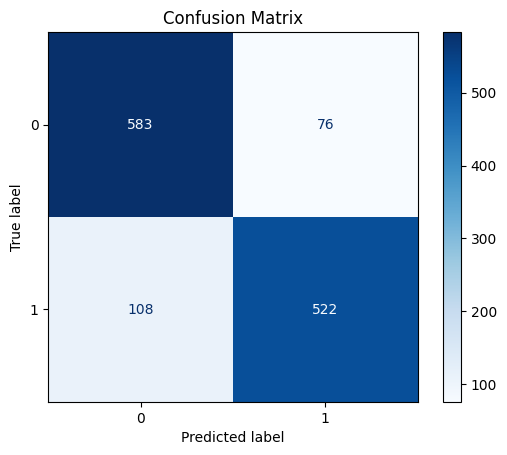

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [66]:
valdation_data=train_data.sample(n=10000, random_state=42)
valdation_data

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
123128,4655,1,300.9,310.7,1368,62.0,12,1
54705,5562,1,300.5,311.3,1543,36.0,190,0
40016,5222,1,300.6,310.4,1499,38.5,114,0
75025,6159,1,297.6,308.4,1502,38.5,130,0
120421,4645,1,300.8,310.7,1539,38.5,203,0
...,...,...,...,...,...,...,...,...
77486,8898,2,300.0,309.6,1587,32.6,158,0
62767,6242,1,297.2,308.2,1583,33.4,15,0
23604,7281,2,296.3,307.4,1350,46.7,35,0
4623,3158,1,301.8,310.8,1399,53.2,174,0


In [67]:
y_valdation=valdation_data['Machine failure']
x_valdiation=valdation_data.drop(['Machine failure','Product ID','Type'],axis=1)
x_valdiation

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
123128,300.9,310.7,1368,62.0,12
54705,300.5,311.3,1543,36.0,190
40016,300.6,310.4,1499,38.5,114
75025,297.6,308.4,1502,38.5,130
120421,300.8,310.7,1539,38.5,203
...,...,...,...,...,...
77486,300.0,309.6,1587,32.6,158
62767,297.2,308.2,1583,33.4,15
23604,296.3,307.4,1350,46.7,35
4623,301.8,310.8,1399,53.2,174


In [68]:
y_valdation

123128    1
54705     0
40016     0
75025     0
120421    0
         ..
77486     0
62767     0
23604     0
4623      0
74502     0
Name: Machine failure, Length: 10000, dtype: int64

In [69]:
y_pred = rf_classifier.predict(x_valdiation)
print("Accuracy:", accuracy_score(y_valdation, y_pred))


Accuracy: 0.8739


Confusion Matrix:
[[8586 1258]
 [   3  153]]


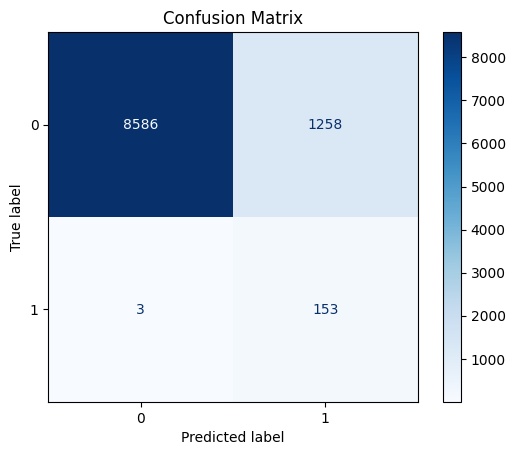

In [70]:
conf_matrix = confusion_matrix(y_valdation, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [71]:
# save the model to assets


import joblib

current_directory  = os.path.dirname(os.getcwd())

model_path = os.path.join(current_directory, "src/assets/classicMLmodels", "random_forest_model.joblib")
joblib.dump(rf_classifier, model_path)

['/home/tarek/Downloads/LLM-projects/GenDrive/src/assets/classicMLmodels/random_forest_model.joblib']